# Gluon example with DALI

## Overview

This is a modified [DCGAN example](https://gluon.mxnet.io/chapter14_generative-adversarial-networks/dcgan.html), which uses DALI for reading and augmenting images.

## Sample

In [1]:
from __future__ import print_function
import os
import matplotlib as mpl
import tarfile
import matplotlib.image as mpimg
from matplotlib import pyplot as plt

import mxnet as mx
from mxnet import gluon
from mxnet import ndarray as nd
from mxnet.gluon import nn, utils
from mxnet import autograd
import numpy as np

/opt/mxnet/python/mxnet/optimizer.py:136: UserWarning: WARNING: New optimizer mxnet.optimizer.NAG is overriding existing optimizer mxnet.optimizer.NAG
  Optimizer.opt_registry[name].__name__))


In [2]:
epochs = 10 # Set low by default for tests, set higher when you actually run this code.
batch_size = 64
latent_z_size = 100

use_gpu = True
ctx = mx.gpu() if use_gpu else mx.cpu()

lr = 0.0002
beta1 = 0.5

In [3]:
lfw_url = 'http://vis-www.cs.umass.edu/lfw/lfw-deepfunneled.tgz'
data_path = 'lfw_dataset'
if not os.path.exists(data_path):
    os.makedirs(data_path)
    data_file = utils.download(lfw_url)
    with tarfile.open(data_file) as tar:
        tar.extractall(path=data_path)

In [4]:
target_wd = 64
target_ht = 64

In [5]:
from nvidia.dali.pipeline import Pipeline
import nvidia.dali.ops as ops
import nvidia.dali.types as types
import numpy as np

class HybridPipe(Pipeline):
    def __init__(self, batch_size, num_threads, device_id):
        super(HybridPipe, self).__init__(batch_size,
                                         num_threads,
                                         device_id,
                                         seed = 12)
        self.input = ops.FileReader(file_root=data_path + "/lfw-deepfunneled/", random_shuffle = True)
        self.decode = ops.nvJPEGDecoder(device = "mixed", output_type = types.RGB)
        self.resize = ops.Resize(device = "gpu",
                                 resize_x = target_wd, resize_y = target_ht,
                                 image_type = types.RGB,
                                 interp_type = types.INTERP_LINEAR)
        self.rotate = ops.Rotate(device = "gpu", interp_type = types.INTERP_LINEAR)
        self.cmnp = ops.CropMirrorNormalize(device = "gpu",
                                            output_dtype = types.FLOAT,
                                            crop = (target_wd, target_ht),
                                            image_type = types.RGB,
                                            mean = [127.5, 127.5, 127.5],
                                            std = [127.5, 127.5, 127.5])
        self.uniform = ops.Uniform(range = (-10., 10.))
        self.iter = 0

    def define_graph(self):
        inputs, labels = self.input(name = "Reader")
        images = self.decode(inputs)
        angle = self.uniform()
        images = self.resize(images)
        images = self.rotate(images, angle = angle)
        output = self.cmnp(images)
        return (output)

    def iter_setup(self):
        pass


In [6]:
pipe = HybridPipe(batch_size=batch_size, num_threads=4, device_id = 0)
pipe.build()

In [7]:
pipe_out = pipe.run()

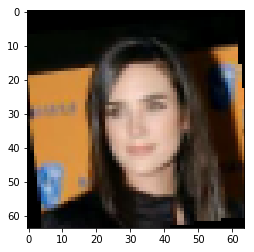

In [8]:
pipe_out_cpu = pipe_out[0].asCPU()
img_chw = pipe_out_cpu.at(20)
%matplotlib inline
plt.imshow((np.transpose(img_chw, (1,2,0))+1.0)/2.0)

In [9]:
from nvidia.dali.plugin.mxnet import DALIGenericIterator
dali_iter = DALIGenericIterator(pipe, ["data"], pipe.epoch_size("Reader"))

In [10]:
# build the generator
nc = 3
ngf = 64
netG = nn.Sequential()
with netG.name_scope():
    # input is Z, going into a convolution
    netG.add(nn.Conv2DTranspose(ngf * 8, 4, 1, 0, use_bias=False))
    netG.add(nn.BatchNorm())
    netG.add(nn.Activation('relu'))
    # state size. (ngf*8) x 4 x 4
    netG.add(nn.Conv2DTranspose(ngf * 4, 4, 2, 1, use_bias=False))
    netG.add(nn.BatchNorm())
    netG.add(nn.Activation('relu'))
    # state size. (ngf*8) x 8 x 8
    netG.add(nn.Conv2DTranspose(ngf * 2, 4, 2, 1, use_bias=False))
    netG.add(nn.BatchNorm())
    netG.add(nn.Activation('relu'))
    # state size. (ngf*8) x 16 x 16
    netG.add(nn.Conv2DTranspose(ngf, 4, 2, 1, use_bias=False))
    netG.add(nn.BatchNorm())
    netG.add(nn.Activation('relu'))
    # state size. (ngf*8) x 32 x 32
    netG.add(nn.Conv2DTranspose(nc, 4, 2, 1, use_bias=False))
    netG.add(nn.Activation('tanh'))
    # state size. (nc) x 64 x 64

# build the discriminator
ndf = 64
netD = nn.Sequential()
with netD.name_scope():
    # input is (nc) x 64 x 64
    netD.add(nn.Conv2D(ndf, 4, 2, 1, use_bias=False))
    netD.add(nn.LeakyReLU(0.2))
    # state size. (ndf) x 32 x 32
    netD.add(nn.Conv2D(ndf * 2, 4, 2, 1, use_bias=False))
    netD.add(nn.BatchNorm())
    netD.add(nn.LeakyReLU(0.2))
    # state size. (ndf) x 16 x 16
    netD.add(nn.Conv2D(ndf * 4, 4, 2, 1, use_bias=False))
    netD.add(nn.BatchNorm())
    netD.add(nn.LeakyReLU(0.2))
    # state size. (ndf) x 8 x 8
    netD.add(nn.Conv2D(ndf * 8, 4, 2, 1, use_bias=False))
    netD.add(nn.BatchNorm())
    netD.add(nn.LeakyReLU(0.2))
    # state size. (ndf) x 4 x 4
    netD.add(nn.Conv2D(1, 4, 1, 0, use_bias=False))

In [11]:
# loss
loss = gluon.loss.SigmoidBinaryCrossEntropyLoss()

# initialize the generator and the discriminator
netG.initialize(mx.init.Normal(0.02), ctx=ctx)
netD.initialize(mx.init.Normal(0.02), ctx=ctx)

# trainer for the generator and the discriminator
trainerG = gluon.Trainer(netG.collect_params(), 'adam', {'learning_rate': lr, 'beta1': beta1})
trainerD = gluon.Trainer(netD.collect_params(), 'adam', {'learning_rate': lr, 'beta1': beta1})

In [ ]:
from datetime import datetime
import time
import logging

real_label = nd.ones((batch_size,), ctx=ctx)
fake_label = nd.zeros((batch_size,),ctx=ctx)

def facc(label, pred):
    pred = pred.ravel()
    label = label.ravel()
    return ((pred > 0.5) == label).mean()
metric = mx.metric.CustomMetric(facc)

stamp =  datetime.now().strftime('%Y_%m_%d-%H_%M')
logging.basicConfig(level=logging.DEBUG)

for epoch in range(epochs):
    tic = time.time()
    btic = time.time()
    iter = 0
    for batches in dali_iter:  # Using DALI iterator
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        data = batches[0].data[0]  # extracting the batch for device 0
        latent_z = mx.nd.random_normal(0, 1, shape=(batch_size, latent_z_size, 1, 1), ctx=ctx)

        with autograd.record():
            # train with real image
            output = netD(data).reshape((-1, 1))
            errD_real = loss(output, real_label)
            metric.update([real_label,], [output,])

            # train with fake image
            fake = netG(latent_z)
            output = netD(fake.detach()).reshape((-1, 1))
            errD_fake = loss(output, fake_label)
            errD = errD_real + errD_fake
            errD.backward()
            metric.update([fake_label,], [output,])

        trainerD.step(data.shape[0])

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        with autograd.record():
            fake = netG(latent_z)
            output = netD(fake).reshape((-1, 1))
            errG = loss(output, real_label)
            errG.backward()

        trainerG.step(data.shape[0])

        # Print log infomation every ten batches
        if iter % 100 == 0:
            name, acc = metric.get()
            logging.info('speed: {} samples/s'.format(batch_size / (time.time() - btic)))
            logging.info('discriminator loss = %f, generator loss = %f, binary training acc = %f at iter %d epoch %d'
                     %(nd.mean(errD).asscalar(),
                       nd.mean(errG).asscalar(), acc, iter, epoch))
        iter = iter + 1
        btic = time.time()
    dali_iter.reset()

    name, acc = metric.get()
    metric.reset()

INFO:root:speed: 222.241457791 samples/s
INFO:root:discriminator loss = 1.505121, generator loss = 6.288426, binary training acc = 0.585938 at iter 0 epoch 0
INFO:root:speed: 649.422288887 samples/s
INFO:root:discriminator loss = 1.596359, generator loss = 12.483607, binary training acc = 0.856126 at iter 100 epoch 0
INFO:root:speed: 655.019377131 samples/s
INFO:root:discriminator loss = 0.521827, generator loss = 6.631699, binary training acc = 0.844450 at iter 200 epoch 0
INFO:root:speed: 659.310065677 samples/s
INFO:root:discriminator loss = 0.300034, generator loss = 4.885581, binary training acc = 0.937500 at iter 0 epoch 1
INFO:root:speed: 616.350547846 samples/s
INFO:root:discriminator loss = 0.200199, generator loss = 3.784022, binary training acc = 0.860226 at iter 100 epoch 1
INFO:root:speed: 584.805042079 samples/s
INFO:root:discriminator loss = 0.717995, generator loss = 6.369466, binary training acc = 0.873834 at iter 200 epoch 1
INFO:root:speed: 664.692635119 samples/s
IN

In [ ]:
def visualize(img_arr):
    plt.imshow(((img_arr.asnumpy().transpose(1, 2, 0) + 1.0) * 127.5).astype(np.uint8))
    plt.axis('off')

In [ ]:
num_image = 8
fig = plt.figure(figsize = (16,8))
for i in range(num_image):
    latent_z = mx.nd.random_normal(0, 1, shape=(1, latent_z_size, 1, 1), ctx=ctx)
    img = netG(latent_z)
    plt.subplot(2,4,i+1)
    visualize(img[0])
plt.show()